In [1]:
import matplotlib.pyplot as plt
import numpy as np
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

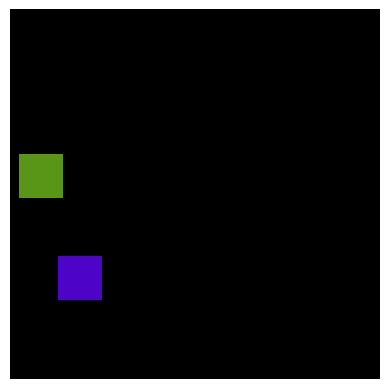

In [2]:
class SquareImagesDataset(Dataset):
    def __init__(self, num_images, img_size=84, square_size=10, num_classes=5):
        self.num_images = num_images
        self.img_size = img_size
        self.square_size = square_size
        self.num_classes = num_classes
        self.data, self.labels = self.generate_dataset()
        
    def generate_dataset(self):
        data = torch.zeros((self.num_images, 3, self.img_size, self.img_size), dtype=torch.float32)
        labels = torch.zeros((self.num_images, 1), dtype=torch.float32)
        for i in range(self.num_images):
            num_squares = np.random.randint(0, self.num_classes)  # Randomly choose between 0 to 4 squares.
            labels[i] = num_squares
            for _ in range(num_squares):
                x = np.random.randint(0, self.img_size - self.square_size)
                y = np.random.randint(0, self.img_size - self.square_size)
                color = torch.tensor(np.random.rand(3), dtype=torch.float32)  # Random color for each square.
                data[i, :, x:x+self.square_size, y:y+self.square_size] = color[:, None, None]
        return data, labels
    
    def to_device(self, device):
        self.data = self.data.to(device)
        self.labels = self.labels.to(device)

    def __len__(self):
        return self.num_images
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

dataset = SquareImagesDataset(10000)
test_dataset = SquareImagesDataset(500)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset.to_device(device)
test_dataset.to_device(device)

def visualize_image(image_tensor):
    image = image_tensor.permute(1, 2, 0).cpu()  # Convert from (C, H, W) to (H, W, C) for visualization.
    plt.imshow(image)
    plt.axis('off')

visualize_image(dataset[0][0])

In [3]:
class TinyCNN(nn.Module):
    def __init__(self):
        super(TinyCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 21 * 21, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Predict a single value for the number of squares.
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer.
        x = self.fc_layers(x)
        return x

model = TinyCNN()
model.to(device)
model

TinyCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=14112, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [4]:
def train_model(model, train_data, test_data, epochs, batch_size=32, learning_rate=1e-5):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                predicted = torch.round(outputs)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.3f}, Test Loss: {test_loss/len(test_loader):.3f}, Accuracy: {100*correct/total}%")

    print("Training complete.")

train_model(model, dataset, test_dataset, epochs=50)

Epoch 1, Loss: 2.307, Test Loss: 1.671, Accuracy: 21.0%
Epoch 2, Loss: 1.456, Test Loss: 1.154, Accuracy: 22.6%
Epoch 3, Loss: 0.844, Test Loss: 0.492, Accuracy: 42.2%
Epoch 4, Loss: 0.321, Test Loss: 0.184, Accuracy: 79.6%
Epoch 5, Loss: 0.175, Test Loss: 0.154, Accuracy: 82.4%
Epoch 6, Loss: 0.158, Test Loss: 0.145, Accuracy: 83.4%
Epoch 7, Loss: 0.151, Test Loss: 0.139, Accuracy: 83.2%
Epoch 8, Loss: 0.146, Test Loss: 0.133, Accuracy: 84.6%
Epoch 9, Loss: 0.141, Test Loss: 0.131, Accuracy: 84.0%
Epoch 10, Loss: 0.136, Test Loss: 0.126, Accuracy: 84.8%
Epoch 11, Loss: 0.133, Test Loss: 0.122, Accuracy: 86.0%
Epoch 12, Loss: 0.129, Test Loss: 0.122, Accuracy: 85.0%
Epoch 13, Loss: 0.125, Test Loss: 0.117, Accuracy: 86.6%
Epoch 14, Loss: 0.122, Test Loss: 0.114, Accuracy: 86.8%
Epoch 15, Loss: 0.118, Test Loss: 0.112, Accuracy: 86.2%
Epoch 16, Loss: 0.115, Test Loss: 0.109, Accuracy: 86.8%
Epoch 17, Loss: 0.112, Test Loss: 0.107, Accuracy: 86.6%
Epoch 18, Loss: 0.109, Test Loss: 0.106,

### Vanilla gradient

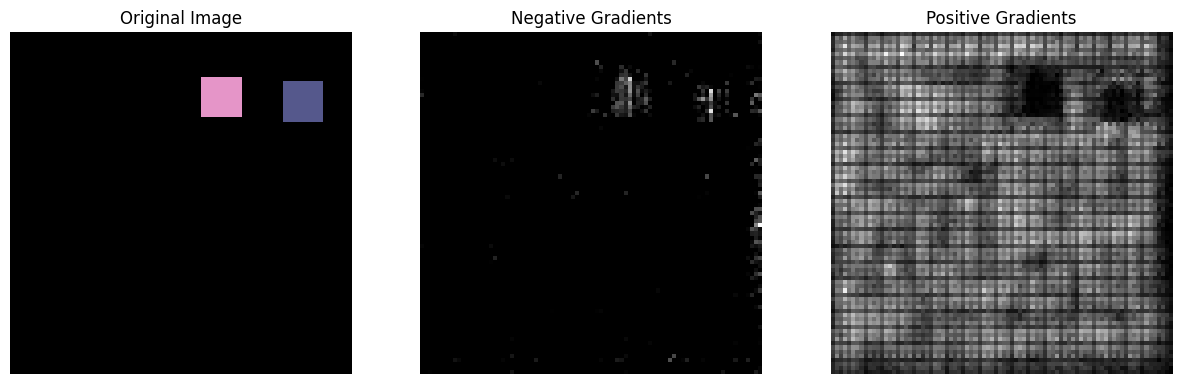

In [17]:
# Generate a new image for prediction
new_dataset = SquareImagesDataset(1)
new_image, true_label = new_dataset[0]

model.to("cpu")
model.eval()
with torch.no_grad():
    prediction = model(new_image.unsqueeze(0))

new_image.requires_grad_(True)

# Perform a forward pass and compute gradients
model.zero_grad()
prediction = model(new_image.unsqueeze(0))
target = torch.tensor([true_label])
loss = nn.MSELoss()(prediction, target.unsqueeze(0))
loss.backward()

gradients = new_image.grad.data

# Sum gradients over the color channels
positive_gradients = torch.clamp(gradients, min=0).sum(dim=0)
negative_gradients = torch.clamp(gradients, max=0).abs().sum(dim=0)

# Plot gradients and the original image
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
axes[0].imshow(new_image.detach().permute(1, 2, 0).numpy())
axes[0].set_title("Original Image")
axes[0].axis('off')

for ax, grad, title in zip(axes[1:], [negative_gradients, positive_gradients], ["Negative Gradients", "Positive Gradients"]):
    ax.imshow(grad.numpy(), cmap='gray')
    ax.set_title(title)
    ax.axis('off')
plt.show()

### Gradient x Input

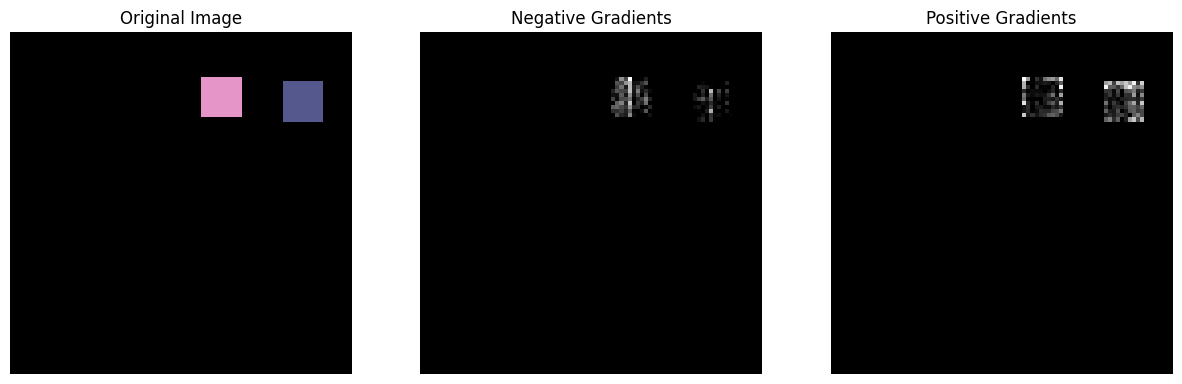

In [18]:
gradients = new_image.grad.data
gradients_input = gradients * new_image

# Sum gradients over the color channels
positive_gradients = torch.clamp(gradients_input, min=0).sum(dim=0)
negative_gradients = torch.clamp(gradients_input, max=0).abs().sum(dim=0)

# Plot gradients and the original image
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
axes[0].imshow(new_image.detach().permute(1, 2, 0).numpy())
axes[0].set_title("Original Image")
axes[0].axis('off')

for ax, grad, title in zip(axes[1:], [negative_gradients, positive_gradients], ["Negative Gradients", "Positive Gradients"]):
    ax.imshow(grad.detach().numpy(), cmap='gray')
    ax.set_title(title)
    ax.axis('off')
plt.show()

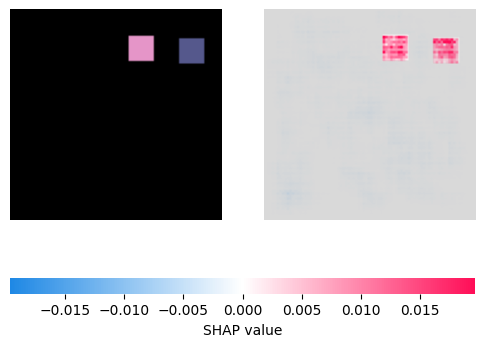

In [19]:
background = dataset.data[:100]
target_observation = new_image.unsqueeze(0)

model.to(device)
model.eval()

explainer = shap.DeepExplainer(model, background)

# Generate SHAP values for the input image
shap_values = explainer.shap_values(target_observation)
shap_values = [np.transpose(shap_values[0], (1, 2, 0))]

# Plot the SHAP values to visualize the explanation
target_observation = target_observation.detach().numpy().astype(np.float32)
target_observation = np.transpose(target_observation, (0, 2, 3, 1)).squeeze()

shap.image_plot(shap_values, target_observation)